In [7]:
from asp.search.mcmc import smooth_box_mask, smooth_mask
from asp.search.objective_fn import ObjectiveFunction
import numpy as np

def booth(x):
    '''f(1,3)=0, -10 < x, y < 10'''
    x, y = x[0], x[1]
    term1 = (x+2*y-7)**2
    term2 = (2*x+y-5)**2
    return np.log(term1 + term2)

def himmelblau(x):
    '''-5 < x, y < 5'''
    x, y = x[0], x[1]
    term1 = (x**2+y-11)**2
    term2 = (x+y**2-7)**2
    return np.log(term1 + term2)


def himmelblau_booth(x):
    output = {
        'x': x[0],
        'y': x[1],
        'himmelblau': himmelblau(x),
        'booth': booth(x)
        }
    return output


space_config = {
    'x': {
        'lower': -5,
        'upper': 5.,
        'distribution': 'uniform',
    },
    'y': {
        'lower': -5,
        'upper': 5.,
        'distribution': 'uniform',
    },
}

output_parameters = ['himmelblau', 'booth']
input_parameters = ['x', 'y']

objectives = {
    'double_constraint': {
        'booth': [['gt', 2],['lt',4]]
    },
    'single_constraint': {
        'himmelblau':['lt', 3.],
    },
    'gaussian_constraint': {

    }
    }

objective_function = ObjectiveFunction(
            himmelblau_booth,
            space_config,
            input_parameters,
            output_parameters,
            objectives
            )

def him_boo(x):
    result = objective_function.sample(
        x.reshape(1,-1), is_normalised=True
    )
    h = result['himmelblau']
    b = result['booth']

    lh = 1 - smooth_mask(h,3., 1e-3)
    lb = smooth_box_mask(b, 2., 4., 1e-3 ) 
    return  np.log(lh*lb+ 1e-8)

In [8]:
import numpy as np


x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)


# Gaussian function
Z =  np.exp(-((X)**2 / (2) + (Y )**2 / (2)))

xy = np.vstack((X.flatten(), Y.flatten())).T

lhs = []
for point in xy:
    lhs.append(him_boo(point))

In [9]:
df = objective_function.as_dataframe()
df['lhs'] = lhs
df.head()

,x,y,himmelblau,booth,satisfactory,lhs
0,-5.000000,-5.0,5.521461,6.784457,0.0,-18.420681
1,-4.949749,-5.0,5.491246,6.777398,0.0,-18.420681
2,-4.899497,-5.0,5.462578,6.770317,0.0,-18.420681
3,-4.849246,-5.0,5.435556,6.763215,0.0,-18.420681
4,-4.798995,-5.0,5.410272,6.756092,0.0,-18.420681


In [10]:
import matplotlib.pyplot as plt 
text_configuration = {
    'usetex': True,
    'axes_labels_size': 14,
    'ticks_labels_size': 12,
    'legend_font_size': 12
}

plt.rc('text', usetex=True)
plt.rc('axes', titlesize=text_configuration['axes_labels_size'])
plt.rc('axes', labelsize=text_configuration['axes_labels_size'])
plt.rc('xtick', labelsize=text_configuration['ticks_labels_size'])
plt.rc('ytick', labelsize=text_configuration['ticks_labels_size'])
plt.rc('legend', fontsize=text_configuration['legend_font_size'])
plt.rc('axes', linewidth=0.2)

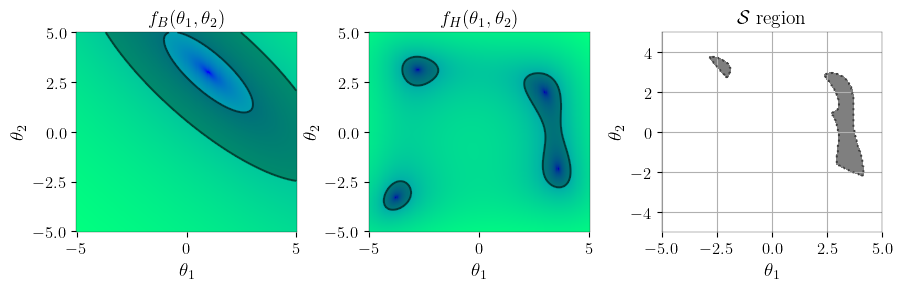

In [11]:
# Plot contour levels
fig, axs = plt.subplots(1,3, figsize=(9,3))
ax = axs[1]

ax.pcolormesh(
    df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape),
    df.himmelblau.to_numpy().reshape(Z.shape), 
           cmap='winter')
ax.contourf( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape),  
           df.himmelblau.to_numpy().reshape(Z.shape), 
           levels=[-10, 3], 
             colors='black',  alpha=0.3)
ax.contour( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape),  
           df.himmelblau.to_numpy().reshape(Z.shape), 
           levels=[-10, 3], 
              colors='black', alpha=0.5)
ax.set_title(r'$f_H(\theta_1, \theta_2)$')
#ax.clabel(contour, inline=True, fontsize=8)

ax = axs[0]

ax.pcolormesh( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape),
         df.booth.to_numpy().reshape(Z.shape), 
          cmap='winter')
ax.contourf( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape), 
           df.booth.to_numpy().reshape(Z.shape), 
           levels=[2, 4], 
              colors='black',  alpha=0.3)
ax.contour( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape),  
           df.booth.to_numpy().reshape(Z.shape), 
           levels=[2, 4], 
             colors='black', alpha=0.5)
ax.set_title(r'$f_B(\theta_1, \theta_2)$')



ax = axs[2]
Z_ = df.lhs.to_numpy().reshape(Z.shape)

contour_filled = ax.contourf( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape), Z_, levels=[-1, np.inf], colors='black', alpha=0.5)
ax.contour( df.x.to_numpy().reshape(X.shape),
    df.y.to_numpy().reshape(Y.shape), Z_, levels=[-1, np.inf], colors='black', alpha=0.5, linestyles='dotted')
ax.set_title(r'$\mathcal{S} \mathrm{\ region}$')
#plt.clabel(contour, inline=True, fontsize=8)
#ax.title('Contour Levels of a Gaussian Function')

#plt.grid(True)
#plt.colorbar()

for ax in axs:
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
plt.tight_layout()
plt.grid(True)
#plt.savefig('test_function_truth.pdf')
plt.show()

In [12]:
from asp.search.mcmc import metropolis_hastings, recursive_proposal, proposal_distribution
import numpy as np

In [229]:
success_hists = []
obj_fns  = []
for i in range(10):
    objective_function = ObjectiveFunction(
                himmelblau_booth,
                space_config,
                input_parameters,
                output_parameters,
                objectives
                )
    
    def him_boo(x):
        result = objective_function.sample(
            x.reshape(1,-1), is_normalised=True
        )
        h = result['himmelblau']
        b = result['booth']
    
        lh = 1 - smooth_mask(h,3., 1e-2)
        lb = smooth_box_mask(b, 2., 4., 1e-2 ) 
        return  lh*lb
    
    
    initial_x = np.random.uniform(0,1,size=(2))
    initial_lh = him_boo(initial_x)
    
    samples, total_proposal_history, total_proposal_likelihood, success_history = metropolis_hastings(
        him_boo,
        proposal_distribution,
        initial_x,
        initial_lh,
        initial_scale=.3,
        num_samples=2210,
        adapt_frequency=100,
        burn_in=1000
        )
    obj_fns.append(objective_function)
    

In [ ]:
from asp.search.utils import dict_to_eval_string

lines = []
mcmc_dfs = []
for obj_fn in obj_fns:
    df = obj_fn.as_dataframe()
    samples = df.iloc[:, :2].to_numpy()
    eval = dict_to_eval_string(objectives)
    select = df.eval(eval)
    df['s'] = select
    lines.append(select)
    mcmc_dfs.append(df)

In [214]:
from mycolorpy import colorlist as mcp
color1=mcp.gen_color(cmap="winter",n=4)


In [ ]:
import matplotlib.pyplot as plt 

obj_fn = obj_fns[np.random.randint(0,10)]
df = obj_fn.as_dataframe()
samples = df.iloc[:, :2].to_numpy()
eval = dict_to_eval_string(objectives)
select = df.eval(eval)
lines.append(select)
    
p_smpls = np.vstack(samples)[select]
n_smpls = np.vstack(samples)[~select]

px, py = p_smpls[:,0], p_smpls[:,1]
nx, ny = n_smpls[:,0], n_smpls[:,1]
# Create a figure



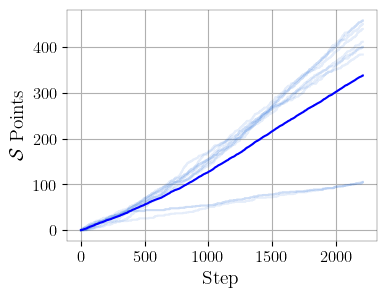

In [217]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ys = []
for select in lines:
    y = np.cumsum(select)
    ys.append(y)
    ax.plot(range(len(y)), y, c=color1[1], alpha=0.1)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0), c=color1[0])

ax.set_ylabel(r'$\mathcal{S}\ \mathrm{Points}$')
ax.set_xlabel(r'$\mathrm{Step}$')

ax.grid()

plt.subplots_adjust(hspace=0.05)
plt.savefig('save/test_function_mcmcmh_10_runs_metrics.pdf')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
color1=mcp.gen_color(cmap="winter",n=8)

class ScatterHistogramPlotter:
    def __init__(self, figsize=(3, 3)):
        # Initialize the figure and axes
        self.fig = plt.figure(figsize=figsize)
        self.scatter_ax = self.fig.add_axes([0.1, 0.1, 0.65, 0.65])
        self.x_hist_ax = self.fig.add_axes([0.1, 0.78, 0.65, 0.15], sharex=self.scatter_ax)
        self.y_hist_ax = self.fig.add_axes([0.78, 0.1, 0.15, 0.65], sharey=self.scatter_ax)
        
        # Configure the axes
        self.x_hist_ax.tick_params(labelleft=True, labelbottom=False)
        self.y_hist_ax.tick_params(labelbottom=True, labelleft=False)
        self.scatter_ax.set_xlabel(r'$\theta_1$')
        self.scatter_ax.set_ylabel(r'$\theta_2$')
        self.x_hist_ax.set_ylabel(r'$\mathrm{Count}$')
        self.y_hist_ax.set_xlabel(r'$\mathrm{Count}$')
        self.x_hist_ax.grid(False)
        self.y_hist_ax.grid(False)

    def add_scatter_points(self, X, Y, colors, alpha=0.7, s=2, label=None, ax_labels=None):
        # Scatter plot

        self.scatter_ax.scatter(X, Y, s=s, c=colors, alpha=alpha)
        
        # Histograms
        self.x_hist_ax.hist(X, bins=30, color=colors, alpha=alpha)
        self.y_hist_ax.hist(Y, bins=30, orientation='horizontal', color=colors, alpha=alpha)
        
        # Adjust limits based on the scatter plot
        self.x_hist_ax.set_xlim(self.scatter_ax.get_xlim())
        self.y_hist_ax.set_ylim(self.scatter_ax.get_ylim())
        if ax_labels:
            self.scatter_ax.set_xlabel(labels[0])
            self.scatter_ax.set_ylabel(labels[1])
        
    def show(self):
        plt.show()
        
class ScatterHistogramPlotter:
    def __init__(self, figsize=(3, 3)):
        self.fig = plt.figure(figsize=figsize)
        self.scatter_ax = self.fig.add_axes([0.1, 0.1, 0.65, 0.65])
        self.x_hist_ax = self.fig.add_axes([0.1, 0.78, 0.65, 0.15], sharex=self.scatter_ax)
        self.y_hist_ax = self.fig.add_axes([0.78, 0.1, 0.15, 0.65], sharey=self.scatter_ax)
        
        self.x_hist_ax.tick_params(labelleft=True, labelbottom=False)
        self.y_hist_ax.tick_params(labelbottom=True, labelleft=False)
        self.scatter_ax.set_xlabel(r'$\theta_1$')
        self.scatter_ax.set_ylabel(r'$\theta_2$')
        self.x_hist_ax.set_ylabel(r'$\mathrm{Count}$')
        self.y_hist_ax.set_xlabel(r'$\mathrm{Count}$')
        self.x_hist_ax.grid(False)
        self.y_hist_ax.grid(False)
        
        # New attribute for legend information
        self.legend_elements = []

    def add_scatter_points(self, X, Y, colors, alpha=0.7, s=2, scatter_label=None, ax_labels=None):
        # Scatter plot
        scatter_plot = self.scatter_ax.scatter(X, Y, s=s, c=colors, alpha=alpha, label=scatter_label)
        
        if scatter_label:
            self.legend_elements.append(scatter_plot)
        
        # Histograms
        self.x_hist_ax.hist(X, bins=30, color=colors, alpha=alpha)
        self.y_hist_ax.hist(Y, bins=30, orientation='horizontal', color=colors, alpha=alpha)
        
        self.x_hist_ax.set_xlim(self.scatter_ax.get_xlim())
        self.y_hist_ax.set_ylim(self.scatter_ax.get_ylim())
        
        if ax_labels:
            self.scatter_ax.set_xlabel(ax_labels[0])
            self.scatter_ax.set_ylabel(ax_labels[1])
        
    def show(self, save=False, name='fig.pdf'):
        # Create legend if there are elements to show
        if self.legend_elements:
            self.scatter_ax.legend(handles=self.legend_elements, loc='lower left')
        if save:
            plt.savefig(name, bbox_inches='tight')
        plt.show()


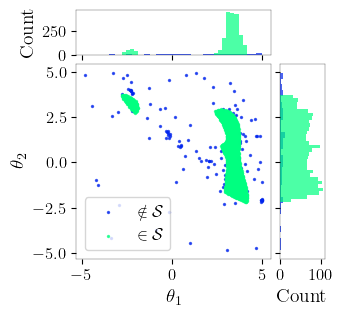

In [261]:
plot = ScatterHistogramPlotter()
plot.add_scatter_points(nx, ny, colors=color1[1], scatter_label=r'$\notin  \mathcal{S}$')
plot.add_scatter_points(px, py, colors=color1[-1],  scatter_label=r'$\in  \mathcal{S}$')
plot.show()


In [274]:
from pathlib import Path
from asp.search.objective_fn import ObjectiveDataSet
from asp.search.utils import dict_to_eval_string
import pandas as pd 

bcastor_dfs = []
bcastor_lines = []
bcastor_metrics = []
for i in range(10):
    ods = ObjectiveDataSet()
    path = Path('/Users/madiaz/Documents/obsidian/Projects/active-search-pheno/experiments_paper/test_function/datasets/hb_bcastor_local')
    run_name = f'run_rdecay_long_17_{i}'
    ods.load_json(path / f'{run_name}/checkpoint')
    met = pd.read_csv(path / f'{run_name}/checkpointmetrics')
    bcastor_metrics.append(met)
    df = pd.DataFrame(ods.dataset)
    filter_string = dict_to_eval_string(objectives)
    select = df.eval(filter_string)
    parameters = list(df.columns)
    df['s'] = select
    bcastor_dfs.append(df)
    bcastor_lines.append(select)

b-CASTOR final points:  2090.1
MCMC final points :  338.1


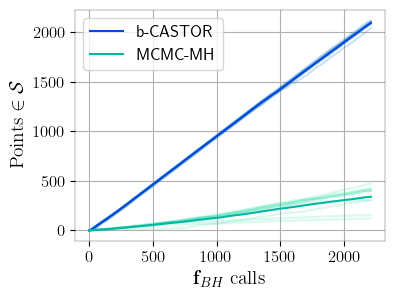

In [361]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ys = []
for select in bcastor_lines:
    y = np.cumsum(select)
    ys.append(y)
    ax.plot(range(len(y)), y, c=color1[3], alpha=0.2)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0), c=color1[2], label=f'b-CASTOR')
final_rate = (ys.mean(axis=0))[-1]
print('b-CASTOR final points: ',final_rate )


ys = []
for select in lines:
    y = np.cumsum(select)
    ys.append(y)
    ax.plot(range(len(y)), y, c=color1[-2], alpha=0.15)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0), c=color1[-3], label=f'MCMC-MH')
final_rate = (ys.mean(axis=0))[-1]
print('MCMC final points : ',final_rate )

ax.set_ylabel(r'$\mathrm{Points} \in  \mathcal{S}$')
ax.set_xlabel(r'$\mathbf{f}_{B H}\ \mathrm{calls}$')

ax.grid()
plt.legend()
plt.subplots_adjust(hspace=0.05)
plt.savefig('save/test_function_bcastor_10_runs_s_points.pdf',bbox_inches='tight')

2211

b-CASTOR final points:  119.9
MCMC final points :  1872.9


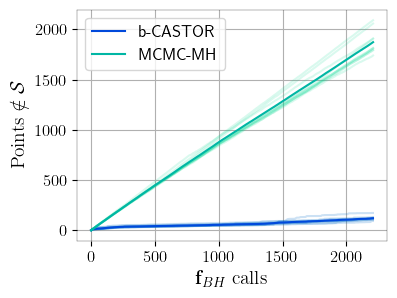

In [360]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ys = []
for select in bcastor_lines:
    y = np.cumsum(~select)
    ys.append(y)
    ax.plot(range(len(y)), y, c=color1[3], alpha=0.2)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0), c=color1[2], label=f'b-CASTOR')
final_rate = (ys.mean(axis=0))[-1]
print('b-CASTOR final points: ',final_rate )

ys = []
for select in lines:
    y = np.cumsum(~select)
    ys.append(y)
    ax.plot(range(len(y)), y, c=color1[-2], alpha=0.15)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0), c=color1[-3], label=f'MCMC-MH')
final_rate = (ys.mean(axis=0))[-1]
print('MCMC final points : ',final_rate )

ax.set_ylabel(r'$\mathrm{Points} \notin  \mathcal{S}$')
ax.set_xlabel(r'$\mathbf{f}_{B H}\ \mathrm{calls}$')

ax.grid()
plt.legend()
plt.subplots_adjust(hspace=0.05)
plt.savefig('save/test_function_bcastor_10_runs_nons_points.pdf',bbox_inches='tight')

b-CASTOR final rate :  94.57
MCMC final rate :  15.29


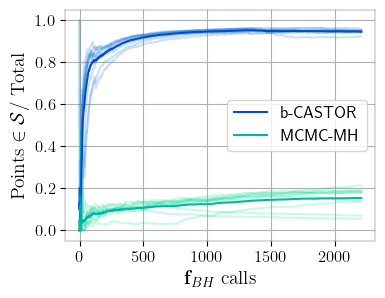

In [358]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ys = []
for select in bcastor_lines:
    y = np.cumsum(select)
    total = np.cumsum(range(len(select)))
    ys.append(y)
    ax.plot(range(len(y)), y/(np.arange(1, len(y)+1)), c=color1[3], alpha=0.2)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0)/(np.arange(1, len(y)+1)), c=color1[2], label=f'b-CASTOR')
final_rate = np.round((ys.mean(axis=0)/(np.arange(1, len(y)+1)))[-1]*100,2)
print('b-CASTOR final rate : ',final_rate )

ys = []
for select in lines:

    y = np.cumsum(select)
    ys.append(y)
    ax.plot(range(len(y)), y/(np.arange(1, len(y)+1)), c=color1[-2], alpha=0.2)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0)/(np.arange(1, len(y)+1)), c=color1[-3], label=f'MCMC-MH')
final_rate = np.round((ys.mean(axis=0)/(np.arange(1, len(y)+1)))[-1]*100,2)
print('MCMC final rate : ',final_rate )

ax.set_ylabel(r'$\mathrm{Points} \in  \mathcal{S}/\ \mathrm{Total}$')
ax.set_xlabel(r'$\mathbf{f}_{B H}\ \mathrm{calls}$')

ax.grid()
plt.legend()
plt.subplots_adjust(hspace=0.05)
plt.savefig('save/test_function_bcastor_10_runs_metrics_s2total.pdf',bbox_inches='tight')

b-CASTOR final rate :  5.43
MCMC final rate :  84.71


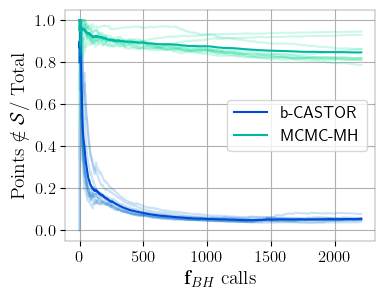

In [357]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ys = []
for select in bcastor_lines:
    y = np.cumsum(~select)
    total = np.cumsum(range(len(select)))
    ys.append(y)
    ax.plot(range(len(y)), y/(np.arange(1, len(y)+1)), c=color1[3], alpha=0.2)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0)/(np.arange(1, len(y)+1)), c=color1[2], label=f'b-CASTOR')
final_rate = np.round((ys.mean(axis=0)/(np.arange(1, len(y)+1)))[-1]*100,2)
print('b-CASTOR final rate : ',final_rate )

ys = []
for select in lines:

    y = np.cumsum(~select)
    ys.append(y)
    ax.plot(range(len(y)), y/(np.arange(1, len(y)+1)), c=color1[-2], alpha=0.2)
ys = np.vstack(ys)
ax.plot(range(ys.shape[-1]), ys.mean(axis=0)/(np.arange(1, len(y)+1)), c=color1[-3], label=f'MCMC-MH')
final_rate = np.round((ys.mean(axis=0)/(np.arange(1, len(y)+1)))[-1]*100,2)
print('MCMC final rate : ',final_rate )


ax.set_ylabel(r'$\mathrm{Points} \notin  \mathcal{S}/\ \mathrm{Total}$')
ax.set_xlabel(r'$\mathbf{f}_{B H}\ \mathrm{calls}$')

ax.grid()
plt.legend()
plt.subplots_adjust(hspace=0.05)
plt.savefig('save/test_function_bcastor_10_runs_metrics_nots2total.pdf',bbox_inches='tight')

In [340]:
ys.mean(axis=0)/np.arange(1,len(y)+1)

array([1.        , 0.95      , 0.96666667, ..., 0.84694432, 0.84701357,
       0.84708277])

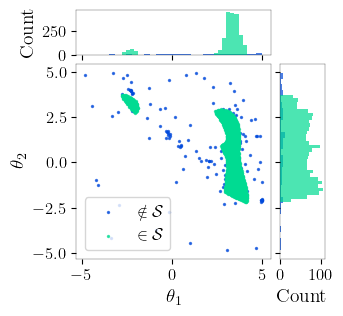

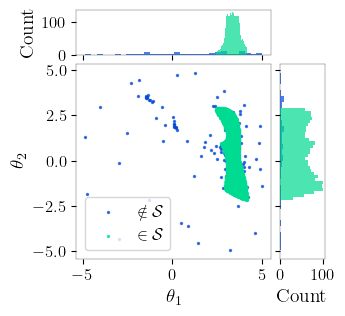

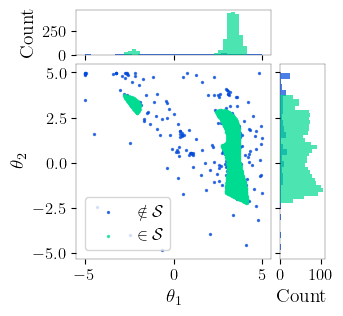

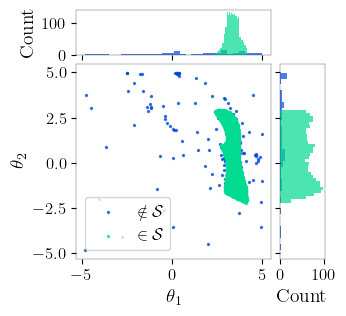

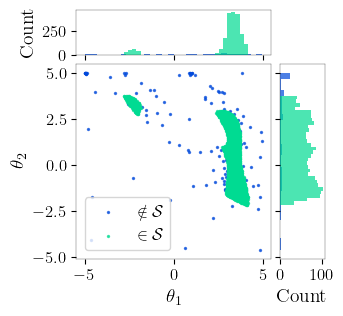

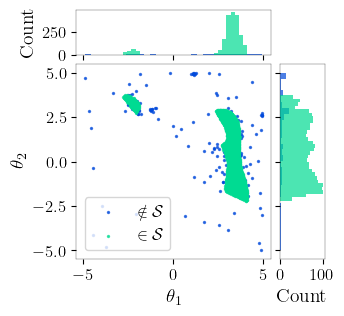

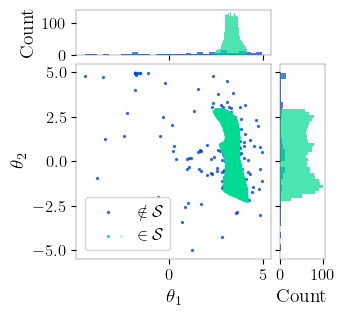

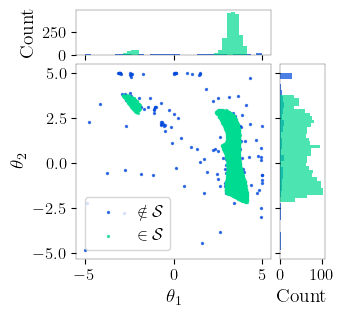

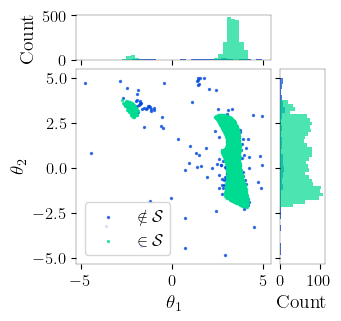

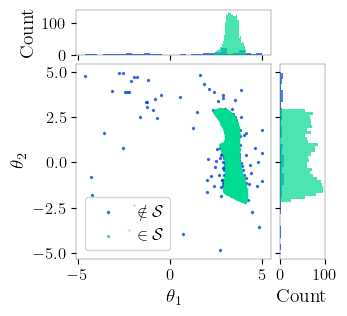

In [263]:
rnd_fig_id = np.random.choice( range(10), 5,replace=False ) 
rnd_fig_id = np.arange(10)
for i in rnd_fig_id:
    df = bcastor_dfs[i]
    plot = ScatterHistogramPlotter()
    select = df.s
    samples = df.iloc[:, :2].to_numpy()
    
    p_smpls = np.vstack(samples)[select]
    n_smpls = np.vstack(samples)[~select]
    
    px, py = p_smpls[:,0], p_smpls[:,1]
    nx, ny = n_smpls[:,0], n_smpls[:,1]
    
    plot.add_scatter_points(nx, ny, colors=color1[2], scatter_label=r'$\notin  \mathcal{S}$')
    plot.add_scatter_points(px, py, colors=color1[-2], scatter_label=r'$\in  \mathcal{S}$')
    #plt.savefig(f'save/bcastor_tf_{i}.pdf',bbox_inches='tight')
    plot.show(save=True, name=f'save/bcastor_tf_{i}.pdf')


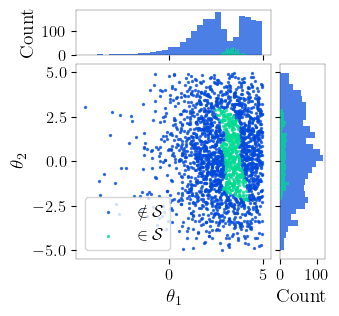

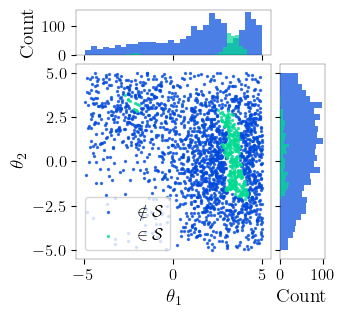

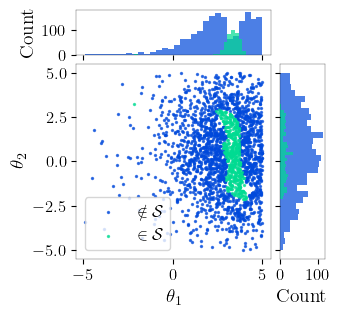

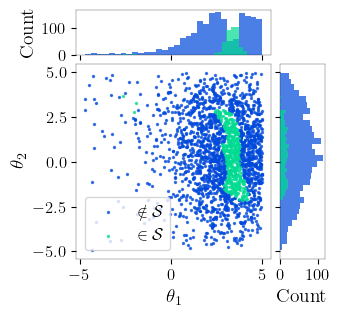

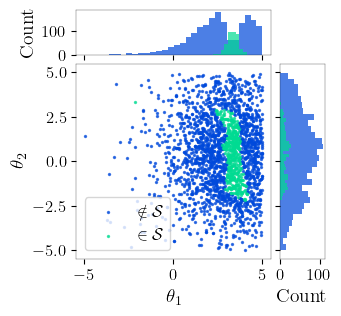

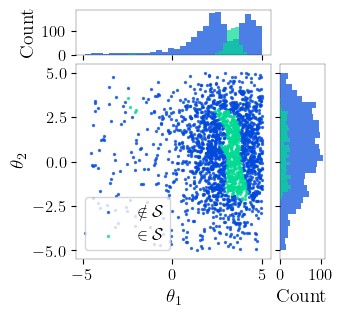

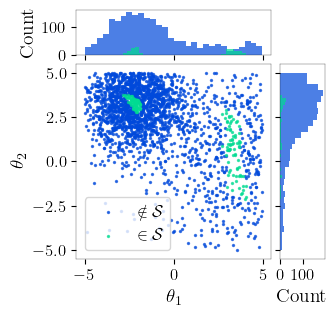

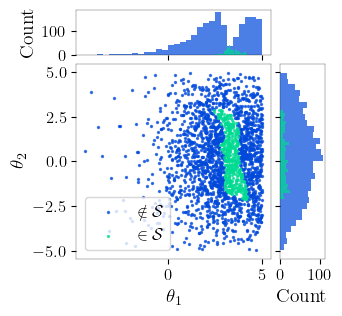

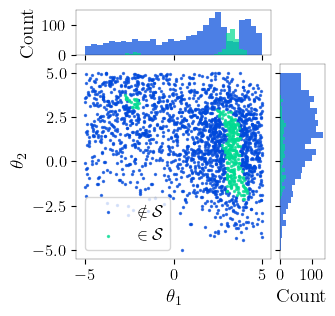

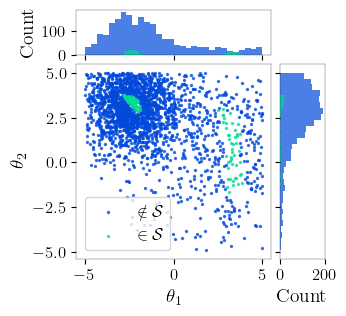

In [264]:
rnd_fig_id = np.random.choice( range(10), 5,replace=False ) 
rnd_fig_id = np.arange(10)

for i in rnd_fig_id:
    df = mcmc_dfs[i]
    plot = ScatterHistogramPlotter()
    select = df.s
    samples = df.iloc[:, :2].to_numpy()
    
    p_smpls = np.vstack(samples)[select]
    n_smpls = np.vstack(samples)[~select]
    
    px, py = p_smpls[:,0], p_smpls[:,1]
    nx, ny = n_smpls[:,0], n_smpls[:,1]
    
    plot.add_scatter_points(nx, ny, colors=color1[2], scatter_label=r'$\notin  \mathcal{S}$')
    plot.add_scatter_points(px, py, colors=color1[-2], scatter_label=r'$\in  \mathcal{S}$')
    #plt.savefig(f'save/bcastor_tf_{i}.pdf',bbox_inches='tight')
    plot.show(save=True, name=f'save/mcmc_tf_{i}.pdf')

